In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = "drive/MyDrive/AI_X/"

### 실험

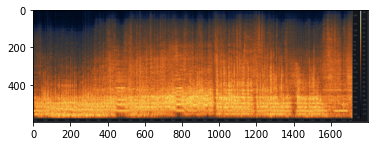

In [ ]:
from PIL import Image
import matplotlib.pylab as plt

 
image1 = Image.open('drive/MyDrive/imim.jpg')
plt.imshow(image1)

In [ ]:
#이미지의 크기 출력
print(image1.size)

(1800, 600)


In [ ]:
# 이미지 자르기 crop함수 이용 ex. crop(가로시작점, 세로시작점, 가로범위, 세로범위)
croppedImage=image1.crop((0,0,1715,580))
 

In [ ]:
croppedImage.size

(1700, 580)

In [ ]:
croppedImage.show()

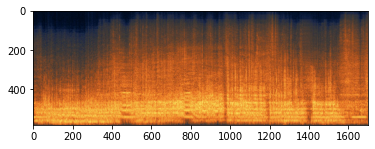

In [ ]:
plt.imshow(croppedImage)

### 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

from pathlib import Path
import pickle, PIL, io, os
import zipfile
from os.path import exists
from tqdm import tqdm

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import walk_through_dir

--2022-11-24 05:24:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-24 05:24:23 (112 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
dataset = DATA_DIR+'Spectrogram_data'
walk_through_dir(dataset);

There are 22 directories and 0 images in 'drive/MyDrive/AI_X/Spectrogram_data'.
There are 0 directories and 1059 images in 'drive/MyDrive/AI_X/Spectrogram_data/강아지짓는소리'.
There are 0 directories and 1120 images in 'drive/MyDrive/AI_X/Spectrogram_data/망치질소리'.
There are 0 directories and 1046 images in 'drive/MyDrive/AI_X/Spectrogram_data/골프연습장의타구음'.
There are 0 directories and 1000 images in 'drive/MyDrive/AI_X/Spectrogram_data/등하원아이들떠드는소리'.
There are 0 directories and 1041 images in 'drive/MyDrive/AI_X/Spectrogram_data/가구끄는소리'.
There are 0 directories and 1044 images in 'drive/MyDrive/AI_X/Spectrogram_data/드럼세탁기소리'.
There are 0 directories and 1063 images in 'drive/MyDrive/AI_X/Spectrogram_data/골프퍼팅(골굴리는소리)'.
There are 0 directories and 1065 images in 'drive/MyDrive/AI_X/Spectrogram_data/런닝머신에서뛰는소리'.
There are 0 directories and 1078 images in 'drive/MyDrive/AI_X/Spectrogram_data/문여닫는소리'.


In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df.to_csv(DATA_DIR+"image_dir.csv")

In [ ]:
image_df = pd.read_csv(DATA_DIR+"image_dir.csv")

In [ ]:

image_df.loc[image_df['Label'] == '드럼세탁기소리', 'Label'] = '세탁기소리'
image_df.loc[image_df['Label'] == '통돌이세탁기소리', 'Label'] = '세탁기소리'

image_df.loc[image_df['Label'] == '어른발걸음소리', 'Label'] = '발걸음소리'
image_df.loc[image_df['Label'] == '아이들발걸음소리', 'Label'] = '발걸음소리'

In [ ]:
image_df.to_csv(DATA_DIR+"image_dir_2_.csv")

In [ ]:
image_df.Label

0        강아지짓는소리
1        강아지짓는소리
2        강아지짓는소리
3        강아지짓는소리
4        강아지짓는소리
               ...        
22270           소리없음
22271           소리없음
22272           소리없음
22273           소리없음
22274           소리없음
Name: Label, Length: 22275, dtype: object

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(image_df.Label)
le.classes_

array(['가구끄는소리', '강아지짓는소리', '골프연습장의타구음',
       '골프퍼팅(골굴리는소리)', '등하원아이들떠드는소리',
       '런닝머신에서뛰는소리', '망치질소리', '문여닫는소리',
       '바이올린연주소리', '샤워할때물소리', '세탁기소리',
       '소리없음', '식기세척기소리',
       '심야에이륜차가빠르게주행하는소리',
       '심야에자동차가빠르게주행하는소리',
       '에어컨실외기의가동소리', '진공청소기소리',
       '피아노연주소리', '화장실물내리는소리', '발걸음소리'], dtype=object)

In [ ]:
train_labels = np.array(le.transform(image_df.Label))
train_labels

array([ 1,  1,  1, ..., 11, 11, 11])

In [ ]:
le.inverse_transform(train_labels)

array(['강아지짓는소리', '강아지짓는소리', '강아지짓는소리', ...,
       '소리없음', '소리없음', '소리없음'], dtype=object)

In [ ]:
len(le.classes_)

20

In [ ]:
IMAGE_SIZE = (150, 50)

In [ ]:
def load_images(files):
    images = None
    for _, im in tqdm(enumerate(files)):
      if _ >= 22265 :
        image = PIL.Image.open(im).crop((136,44,972,314)).convert('RGB').resize(IMAGE_SIZE)
        image = np.expand_dims(np.array(image, dtype=int), axis=0)
        images = image if images is None else np.append(images, image, axis=0)
      else :
        image = PIL.Image.open(im).crop((0,0,1715,580)).convert('RGB').resize(IMAGE_SIZE)
        image = np.expand_dims(np.array(image, dtype=int), axis=0)
        images = image if images is None else np.append(images, image, axis=0)
    return images

In [ ]:
TRAIN_IMAGES_FILE = os.path.join(DATA_DIR + "pkl/null_add/RGB/150_50/train_images.pkl")

if exists(TRAIN_IMAGES_FILE):
    with open(TRAIN_IMAGES_FILE, 'rb') as f:
        train_images = pickle.load(f)
else:
    train_images = load_images(image_df.Filepath)
    with open(TRAIN_IMAGES_FILE, 'wb') as f:
        pickle.dump(train_images, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
train_images.shape

(22275, 50, 150, 3)

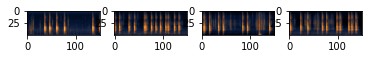

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 4, 1)
ax2 = fig.add_subplot(1, 4, 2)
ax3 = fig.add_subplot(1, 4, 3)
ax4 = fig.add_subplot(1, 4, 4)

ax1.imshow(train_images[0]) # 첫 번째 훈련용 데이터
ax2.imshow(train_images[1]) # 두 번째 훈련용 데이터
ax3.imshow(train_images[2]) # 세 번째 훈련용 데이터
ax4.imshow(train_images[3]) # 네 번째 훈련용 데이터

In [ ]:
x = train_images
y = train_labels

X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, shuffle=True, stratify=train_labels)
X_train.shape, X_valid.shape

((17820, 50, 150, 3), (4455, 50, 150, 3))

In [ ]:
X_train = np.array(X_train) / 255
X_valid = np.array(X_valid) / 255

In [ ]:
import tensorflow as tf

mobile_model = tf.keras.applications.MobileNetV2(
    input_shape=(50, 150, 3),
    include_top=False, # Remove classification head
    weights='imagenet')

for layer in mobile_model.layers:
    layer.trainable = False

model = tf.keras.Sequential(
    [mobile_model,
     Flatten(),
     Dropout(0.5),
     Dense(512, activation='relu'),
     Dense(256, activation='relu'),
     Dense(128, activation='relu'),
     Dense(units=(len(le.classes_)), activation='softmax')])

model.compile(optimizer="rmsprop", loss='sparse_categorical_crossentropy', metrics=['accuracy']) #optimizer : rmsprop, adam
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 2, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dropout (Dropout)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 512)               6554112   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                        

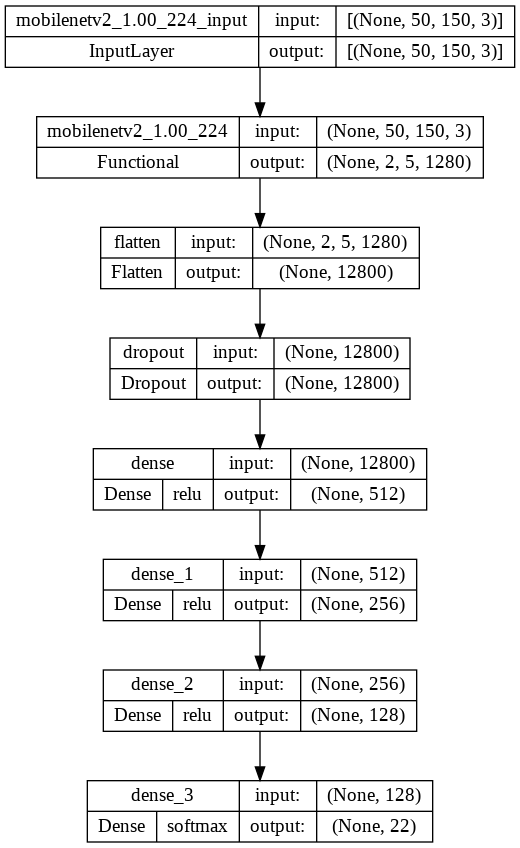

In [ ]:
plot_model(model, show_shapes=True, show_layer_activations=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1,factor=0.2, min_lr=0.000001)

In [ ]:
model.fit(
    X_train,
    y_train,
    # Use your own validation set.
    validation_data=(X_valid, y_valid),
    epochs=100,
    callbacks = [early_stopping, learning_rate_reduction]
)
print("Accuracy:", model.evaluate(X_valid, y_valid)[1])

Epoch 1/100
557/557 [==============================] - 15s 18ms/step - loss: 0.9859 - accuracy: 0.7195 - val_loss: 0.4988 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 2/100
557/557 [==============================] - 9s 15ms/step - loss: 0.4957 - accuracy: 0.8453 - val_loss: 0.4742 - val_accuracy: 0.8566 - lr: 0.0010
Epoch 3/100
557/557 [==============================] - 9s 16ms/step - loss: 0.4317 - accuracy: 0.8699 - val_loss: 0.4575 - val_accuracy: 0.8651 - lr: 0.0010
Epoch 4/100
557/557 [==============================] - 9s 16ms/step - loss: 0.3930 - accuracy: 0.8835 - val_loss: 0.4028 - val_accuracy: 0.8914 - lr: 0.0010
Epoch 5/100
557/557 [==============================] - 9s 16ms/step - loss: 0.3749 - accuracy: 0.8941 - val_loss: 0.4548 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 6/100
557/557 [==============================] - 9s 16ms/step - loss: 0.3460 - accuracy: 0.9043 - val_loss: 0.4931 - val_accuracy: 0.8826 - lr: 0.0010
Epoch 7/100
557/557 [==============================] - 9s

In [ ]:
y_pred = le.inverse_transform(np.array([np.argmax(pred) for pred in model.predict(X_valid)]))
y_test = le.inverse_transform(y_valid)

140/140 [==============================] - 2s 9ms/step


In [ ]:
print(classification_report(y_test, y_pred))

                                      precision    recall  f1-score   support

                       가구끄는소리       0.82      0.82      0.82       208
                   강아지짓는소리       0.93      0.92      0.92       212
             골프연습장의타구음       0.93      0.94      0.94       209
         골프퍼팅(골굴리는소리)       0.94      0.94      0.94       213
          등하원아이들떠드는소리       0.97      0.97      0.97       200
            런닝머신에서뛰는소리       0.99      0.98      0.98       213
                        망치질소리       0.94      0.92      0.93       224
                     문여닫는소리       0.86      0.88      0.87       216
                 바이올린연주소리       0.98      1.00      0.99       225
                    샤워할때물소리       0.96      0.98      0.97       211
                         세탁기소리       0.87      0.88      0.87       425
                          소리없음       1.00      1.00      

In [ ]:
model.save(DATA_DIR+"/h5/null/model_Transfer_Learning_2_.h5")

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model(DATA_DIR+"model_Transfer_Learning.h5")

In [ ]:
y_pred = le.inverse_transform(np.array([np.argmax(pred) for pred in loaded_model.predict(X_valid)]))
y_test = le.inverse_transform(y_valid)

209/209 [==============================] - 3s 9ms/step


In [ ]:
print(classification_report(y_test, y_pred))

                                      precision    recall  f1-score   support

                       가구끄는소리       0.86      0.83      0.84       312
                   강아지짓는소리       0.94      0.96      0.95       318
             골프연습장의타구음       0.94      0.95      0.95       314
         골프퍼팅(골굴리는소리)       0.95      0.94      0.94       319
                    드럼세탁기소리       0.82      0.78      0.80       313
          등하원아이들떠드는소리       0.98      1.00      0.99       300
            런닝머신에서뛰는소리       0.98      1.00      0.99       320
                        망치질소리       0.94      0.94      0.94       336
                     문여닫는소리       0.86      0.89      0.87       323
                 바이올린연주소리       0.99      1.00      1.00       337
                    샤워할때물소리       0.98      0.99      0.98       316
                    식기세척기소리       0.91      0.92      